# Oregon EDA with the 2016 Presidential Election

One of the states we wanted to examine in our exploration of voter turnout and education is Oregon, a typically 'Blue' state. We will examine voter turnout variables, 2016 election outcome variables, and the correspondence they have to any education-related variables in the state's dataset.

In [1]:
# libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# functions
from pyspark.sql.functions import col, countDistinct, round, when, translate, max, min

In [2]:
# read in Oregon parquet file
bucket_dir = 'gs://pstat135-voter-file/VM2Uniform/'
OR_fulldf = spark.read.parquet(bucket_dir + 'VM2Uniform--OR--2021-02-05')

Below is a list of variables related to voter turnout, the outcome of the 2016 presidential election, and education within the state of Oregon.

In [3]:
# limit dataset to relevant variables (education + 2016 general election)
keep = ['LALVOTERID', 'County', 'Board_of_Education_District', 'County_Board_of_Education_District', 'CommercialData_Education',
        'CommercialData_AreaMedianEducationYears', 'CommercialDataLL_Interest_in_Education_Online_In_Household',
        'ElectionReturns_G16_Cnty_Margin_Clinton_D', 'ElectionReturns_G16_Cnty_Percent_Clinton_D', 
        'ElectionReturns_G16_Cnty_Vote_Clinton_D', 'ElectionReturns_G16_Cnty_Margin_Trump_R',
        'ElectionReturns_G16_Cnty_Percent_Trump_R', 'ElectionReturns_G16_Cnty_Vote_Trump_R',
        'ElectionReturns_G16CountyTurnoutAllRegisteredVoters', 'ElectionReturns_G16CountyTurnoutDemocrats',
        'ElectionReturns_G16CountyTurnoutIndependentsAllOthers', 'ElectionReturns_G16CountyTurnoutRepublicans']
OR_df = OR_fulldf.select(keep)

### Checking for Missing Values in Voter ID and County columns

First we will find the number of registered voters within the state of Oregon:

In [4]:
# count number of distinct voter IDs in Oregon dataset
total_state_voters_OR = OR_df.select(countDistinct('LALVOTERID'))
total_state_voters_OR.show()

+--------------------------+
|count(DISTINCT LALVOTERID)|
+--------------------------+
|                   3166785|
+--------------------------+



We used a heat map to check if there were any missing values in the Voter ID column and found that none were missing.

<AxesSubplot:>

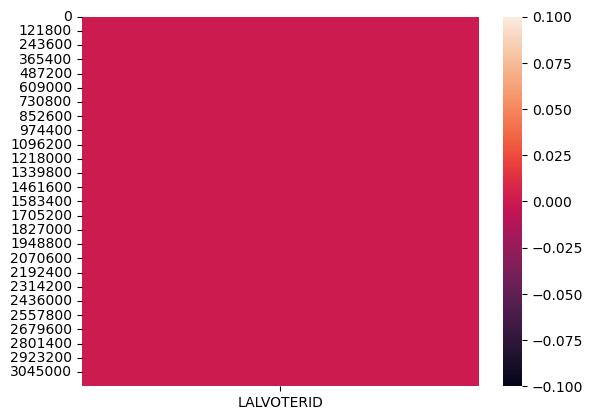

In [5]:
# check if there are any missing values in the voter ID column
# select OR voter IDs
ID_list = OR_df.select('LALVOTERID')
ID_list_pd = ID_list.toPandas()
# Convert all values to T/F
ID_tf = ID_list_pd.isnull()
# Plot it
sns.heatmap(data=ID_tf)

We also wanted to find the number of Oregon counties contained in this dataset:

In [6]:
# count number of Counties in Oregon dataset
num_counties_OR = OR_df.select(countDistinct('County'))
num_counties_OR.show()

+----------------------+
|count(DISTINCT County)|
+----------------------+
|                    36|
+----------------------+



And we used a heatmap to check if there were any missing values in the County column and found that none were missing.

<AxesSubplot:>

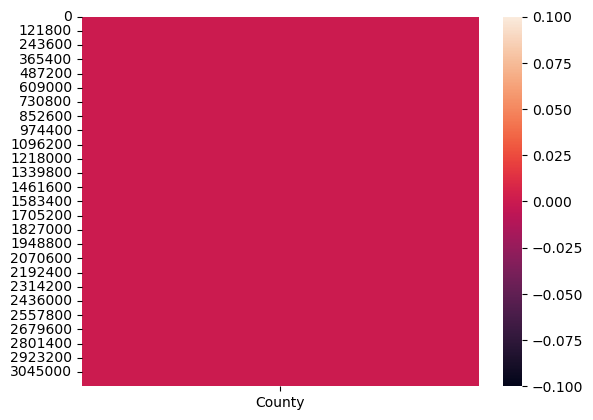

In [7]:
# check if there are any missing values in the county column
# select OR counties
county_list = OR_df.select('County')
county_list_pd = county_list.toPandas()
# Convert all values to T/F
county_tf = county_list_pd.isnull()
# Plot it
sns.heatmap(data=county_tf)

### Exploring Voter Turnout in Oregon

Now we will take a deeper look at the content of the voter turnout variables in this dataset. The dataset contains columns with the turnout of all registered voters, the turnout of Democrat voters, the turnout of Republican voters, and the turnout of Independent/Other voters for each Oregon county.

In [8]:
# get voter turnout stats per county in Oregon
OR_df = OR_df.withColumnRenamed("ElectionReturns_G16CountyTurnoutAllRegisteredVoters", "CountyTurnoutAll") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutDemocrats", "CountyTurnoutDem") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutIndependentsAllOthers", "CountyTurnoutOther") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutRepublicans", "CountyTurnoutRep")
cty_voter_turnout_OR = OR_df.select('County', 'CountyTurnoutAll', 'CountyTurnoutDem',
                                'CountyTurnoutOther', 'CountyTurnoutRep').distinct().orderBy('County') # unique values per each county
cty_voter_turnout_OR.show()

+----------+----------------+----------------+------------------+----------------+
|    County|CountyTurnoutAll|CountyTurnoutDem|CountyTurnoutOther|CountyTurnoutRep|
+----------+----------------+----------------+------------------+----------------+
|     BAKER|             81%|             90%|               53%|            100%|
|    BENTON|             86%|             98%|               64%|             96%|
| CLACKAMAS|             82%|             95%|               57%|             97%|
|   CLATSOP|             81%|             99%|               54%|            100%|
|  COLUMBIA|             80%|             95%|               55%|             99%|
|      COOS|             79%|             98%|               51%|            100%|
|     CROOK|             82%|             95%|               55%|            100%|
|     CURRY|             81%|            100%|               53%|            100%|
| DESCHUTES|             83%|             98%|               59%|            100%|
|   

From a first glance at these variables, there is a few things of note: overall, the voter turnout across all categories is rather high (75% or more), aside from Independent/Other voter turnout, which is noticably lower (40-60%). Additionally, Republican voter turnout is noticably higher overall; in every Oregon county, all or almost all of registered Republican voters voted.

In [9]:
# remove percentages and convert to integer values 
cty_voter_turnout_OR = cty_voter_turnout_OR.withColumn('CountyTurnoutPrcnt', translate(col('CountyTurnoutAll'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntDem', translate(col('CountyTurnoutDem'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntRep', translate(col('CountyTurnoutRep'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntOther', translate(col('CountyTurnoutOther'),'%', ''))\
                    .drop('CountyTurnoutAll', 'CountyTurnoutDem', 'CountyTurnoutRep', 'CountyTurnoutOther')

from pyspark.sql.types import IntegerType
voter_turnout_OR_CLEAN = cty_voter_turnout_OR.withColumn('CountyTurnoutInt', cty_voter_turnout_OR['CountyTurnoutPrcnt'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutDemInt', cty_voter_turnout_OR['CountyTurnoutPrcntDem'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutRepInt', cty_voter_turnout_OR['CountyTurnoutPrcntRep'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutOtherInt', cty_voter_turnout_OR['CountyTurnoutPrcntOther'].cast(IntegerType()))\
                        .drop('CountyTurnoutPrcnt', 'CountyTurnoutPrcntDem', 'CountyTurnoutPrcntRep', 'CountyTurnoutPrcntOther')

Below, we will find the maximum and minimum voter turnout values to examine which counties had the highest and lowest voter turnout across all categories.

In [10]:
# find min and max for turnout across all categories
voter_turnout_OR_CLEAN.select(max('CountyTurnoutInt'), max('CountyTurnoutDemInt'), max('CountyTurnoutRepInt'), max('CountyTurnoutOtherInt')).show()
voter_turnout_OR_CLEAN.select(min('CountyTurnoutInt'), min('CountyTurnoutDemInt'), min('CountyTurnoutRepInt'), min('CountyTurnoutOtherInt')).show()


+---------------------+------------------------+------------------------+--------------------------+
|max(CountyTurnoutInt)|max(CountyTurnoutDemInt)|max(CountyTurnoutRepInt)|max(CountyTurnoutOtherInt)|
+---------------------+------------------------+------------------------+--------------------------+
|                   86|                     100|                     100|                        64|
+---------------------+------------------------+------------------------+--------------------------+



+---------------------+------------------------+------------------------+--------------------------+
|min(CountyTurnoutInt)|min(CountyTurnoutDemInt)|min(CountyTurnoutRepInt)|min(CountyTurnoutOtherInt)|
+---------------------+------------------------+------------------------+--------------------------+
|                   73|                      88|                      94|                        46|
+---------------------+------------------------+------------------------+--------------------------+



In [11]:
# find counties w min and max for all turnout
OR_turnout_max_min = voter_turnout_OR_CLEAN.filter((col('CountyTurnoutInt')==86) | (col('CountyTurnoutInt')==73))
OR_turnout_max_min.show()

+--------+----------------+-------------------+-------------------+---------------------+
|  County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+--------+----------------+-------------------+-------------------+---------------------+
|  BENTON|              86|                 98|                 96|                   64|
|   GRANT|              86|                 94|                100|                   62|
|  HARNEY|              86|                 94|                100|                   59|
|UMATILLA|              73|                 88|                100|                   48|
+--------+----------------+-------------------+-------------------+---------------------+



The Oregon counties Benton, Grant, and Harney have the highest overall voter turnout in the state, while Umatilla has the lowest.

In [12]:
# find counties w min and max for dem turnout
OR_dem_turnout_max_min = voter_turnout_OR_CLEAN.filter((col('CountyTurnoutDemInt')==100) | (col('CountyTurnoutDemInt')==88))
OR_dem_turnout_max_min.show()

+--------+----------------+-------------------+-------------------+---------------------+
|  County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+--------+----------------+-------------------+-------------------+---------------------+
|   CURRY|              81|                100|                100|                   53|
|UMATILLA|              73|                 88|                100|                   48|
+--------+----------------+-------------------+-------------------+---------------------+



The Oregon county Curry has the highest democrat voter turnout with 100% of all registered democrats voting, while Umatilla has the lowest democrat turnout at 88%.

In [13]:
# find counties w min and max for rep turnout
OR_rep_turnout_max_min = voter_turnout_OR_CLEAN.filter((col('CountyTurnoutRepInt')==100) | (col('CountyTurnoutRepInt')==94))
OR_rep_turnout_max_min.show()
OR_rep_turnout_max_min.filter(col('CountyTurnoutRepInt')==100).count()

+----------+----------------+-------------------+-------------------+---------------------+
|    County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+----------+----------------+-------------------+-------------------+---------------------+
|     BAKER|              81|                 90|                100|                   53|
|   CLATSOP|              81|                 99|                100|                   54|
|      COOS|              79|                 98|                100|                   51|
|     CROOK|              82|                 95|                100|                   55|
|     CURRY|              81|                100|                100|                   53|
| DESCHUTES|              83|                 98|                100|                   59|
|     GRANT|              86|                 94|                100|                   62|
|    HARNEY|              86|                 94|                100|           

21

21 Oregon counties have a 100% voter turnout for registered Republican Voters, and only one county, Multnomah, had the minimum Republican voter turnout with 94%. 

In [14]:
# find counties w min and max for other turnout
OR_other_turnout_max_min = voter_turnout_OR_CLEAN.filter((col('CountyTurnoutOtherInt')==64) | (col('CountyTurnoutOtherInt')==46))
OR_other_turnout_max_min.show()

+-------+----------------+-------------------+-------------------+---------------------+
| County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+-------+----------------+-------------------+-------------------+---------------------+
| BENTON|              86|                 98|                 96|                   64|
|MALHEUR|              76|                 93|                100|                   46|
+-------+----------------+-------------------+-------------------+---------------------+



The Oregon county with the maximum voter turnout for Independent/Other voters was Benton county (also one of the counties in the state with the highest overall voter turnout) and the county with the lowest Independent/Other voter turnout was Malheur.

Considering that the state of Oregon was 'Blue' in the 2016 presidential election, the most notable finding from the above exploration is how high Republican voter turnout was across all counties within the state. This finding can implicate some characteristics of the party at the time and how motivated/persuaded/passionate they might have been to vote in the 2016 election.

### Exploring the 2016 General Election Outcome in Oregon

Now we will take a closer look at the content of the 2016 presidential election outcome variables in this dataset. The dataset contains columns with both the number of votes and the proportion of votes for both presidential candidates (Hillary Clinton (D) and Donald Trump (R)) for each Oregon county.

In [15]:
# get election results per county in Oregon
OR_df = OR_df.withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Clinton_D", "Cnty_Percent_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Clinton_D", "Cnty_Vote_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Trump_R", "Cnty_Percent_R") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Trump_R", "Cnty_Vote_R")
election_results_OR = OR_df.select('County',
                                   'Cnty_Percent_D', 
                                   'Cnty_Vote_D',
                                   'Cnty_Percent_R', 
                                   'Cnty_Vote_R').distinct().orderBy('County')
election_results_OR.show()

+----------+--------------+-----------+--------------+-----------+
|    County|Cnty_Percent_D|Cnty_Vote_D|Cnty_Percent_R|Cnty_Vote_R|
+----------+--------------+-----------+--------------+-----------+
|     BAKER|           20%|       1797|           71%|       6218|
|    BENTON|           60%|      29193|           28%|      13445|
| CLACKAMAS|           48%|     102095|           41%|      88392|
|   CLATSOP|           47%|       9252|           41%|       8138|
|  COLUMBIA|           38%|      10167|           50%|      13217|
|      COOS|           33%|      10448|           57%|      17865|
|     CROOK|           22%|       2637|           70%|       8511|
|     CURRY|           34%|       4300|           57%|       7212|
| DESCHUTES|           43%|      42444|           46%|      45692|
|   DOUGLAS|           26%|      14096|           65%|      34582|
|   GILLIAM|           23%|        239|           66%|        671|
|     GRANT|           17%|        739|           74%|       3

From a first glace at this table, we can see that while there are some counties that had a noticable divide in their preference towards presidential candidate (ex: Baker county's preference for Trump, Benton's preference for Clinton), there are some counties that experienced more of a close race between candidates (ex: Deschutes county, Clatsop county, etc.).

In [16]:
# remove percentages and convert to integer values 
election_results_OR = election_results_OR.withColumn('Cnty_Prcnt_D', translate(col('Cnty_Percent_D'),'%', ''))\
                    .withColumn('Cnty_Prcnt_R', translate(col('Cnty_Percent_R'),'%', ''))\
                    .drop('Cnty_Percent_D', 'Cnty_Percent_R')

election_results_OR_CLEAN = election_results_OR.withColumn('Cnty_Prcnt_D_Int', election_results_OR['Cnty_Prcnt_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Prcnt_R_Int', election_results_OR['Cnty_Prcnt_R'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_D_Int', election_results_OR['Cnty_Vote_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_R_Int', election_results_OR['Cnty_Vote_R'].cast(IntegerType()))\
                        .drop('Cnty_Prcnt_D', 'Cnty_Prcnt_R', 'Cnty_Vote_D', 'Cnty_Vote_R')

In [33]:
# count how many Oregon counties Clinton got the majority vote in
election_results_OR_CLEAN.filter(col('Cnty_Prcnt_D_Int')>col('Cnty_Prcnt_R_Int')).count()

8

In [34]:
# count how many counties Trump got the majority vote in
election_results_OR_CLEAN.filter(col('Cnty_Prcnt_D_Int')<col('Cnty_Prcnt_R_Int')).count()

28

The Democrat presidential candidate won the majority of votes in 8 Oregon counties, while the Republican presidential candidate won the majority of votes in 28 Oregon counties. We know that the Democrat candidate won the state of Oregon in the 2016 election, so we can infer that the 8 counties with the Democrat majority must have been the most populous counties in the state.

Again, we will find the maximum and minimum values for proportion of votes for each candidate to examine what counties had the highest and lowest proportion of votes for both parties.

In [17]:
# find min and max for percent of votes for democrat and republican
election_results_OR_CLEAN.select(max('Cnty_Prcnt_D_Int'), max('Cnty_Prcnt_R_Int')).show()
election_results_OR_CLEAN.select(min('Cnty_Prcnt_D_Int'), min('Cnty_Prcnt_R_Int')).show()

+---------------------+---------------------+
|max(Cnty_Prcnt_D_Int)|max(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                   73|                   77|
+---------------------+---------------------+



+---------------------+---------------------+
|min(Cnty_Prcnt_D_Int)|min(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                   16|                   17|
+---------------------+---------------------+



In [18]:
# find counties w min and max percent of votes for Democrat
OR_D_Prcnt_max_min = election_results_OR_CLEAN.filter((col('Cnty_Prcnt_D_Int')==73) | (col('Cnty_Prcnt_D_Int')==16))
OR_D_Prcnt_max_min.show()
OR_R_Prcnt_max_min = election_results_OR_CLEAN.filter((col('Cnty_Prcnt_R_Int')==77) | (col('Cnty_Prcnt_R_Int')==17))
OR_R_Prcnt_max_min.show()

+---------+----------------+----------------+---------------+---------------+
|   County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+---------+----------------+----------------+---------------+---------------+
|     LAKE|              16|              77|            639|           3022|
|MULTNOMAH|              73|              17|         292561|          67954|
+---------+----------------+----------------+---------------+---------------+



+---------+----------------+----------------+---------------+---------------+
|   County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+---------+----------------+----------------+---------------+---------------+
|     LAKE|              16|              77|            639|           3022|
|MULTNOMAH|              73|              17|         292561|          67954|
+---------+----------------+----------------+---------------+---------------+



We found that Multnomah county had the highest proportion of votes for Clinton in the 2016 presidential election while Lake county has the highest proportion of votes for Trump.

### Exploring Median Education Years by County

To examine the relationship between education and voter turnout/outcome, we will take a closer look at one of the education variables contained in the dataset: Medican Education Years in voters. Below, we create a histogram of each Oregon county's median years of education in voters.

<AxesSubplot:ylabel='County'>

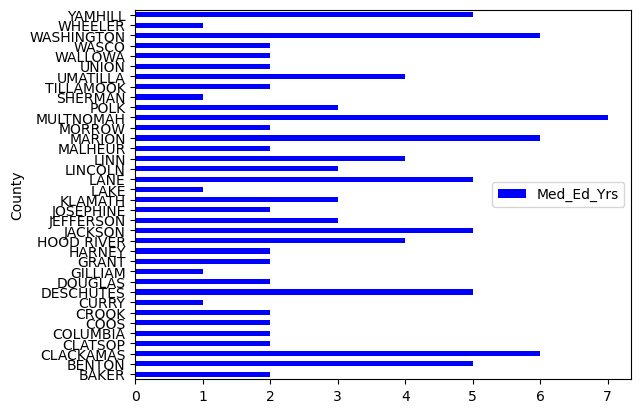

In [19]:
# plot median education years per county using CommercialData_AreaMedianEducationYears
OR_df = OR_df.withColumnRenamed('CommercialData_AreaMedianEducationYears', 'Med_Ed_Yrs')
ed_yrs_by_cty_OR = OR_df.groupBy('County').agg(countDistinct('Med_Ed_Yrs')).orderBy('County')
ed_yrs_by_cty_OR = ed_yrs_by_cty_OR.withColumn('Med_Ed_Yrs', col('count(Med_Ed_Yrs)')).drop(col('count(Med_Ed_Yrs)'))
ed_yrs_by_cty_pd_OR = ed_yrs_by_cty_OR.toPandas()
ed_yrs_by_cty_pd_OR.plot(kind='barh', x='County', y='Med_Ed_Yrs', color='blue')

In [20]:
# check count of counties for each value of median education years
ed_yrs_by_cty_cnt_OR = ed_yrs_by_cty_OR.groupBy('Med_Ed_Yrs').agg(countDistinct('County')).orderBy('Med_Ed_Yrs')
ed_yrs_by_cty_cnt_OR.show()

+----------+-------------+
|Med_Ed_Yrs|count(County)|
+----------+-------------+
|         1|            5|
|         2|           15|
|         3|            4|
|         4|            3|
|         5|            5|
|         6|            3|
|         7|            1|
+----------+-------------+



In the above histogram and corresponding count table, we can draw a few conclusions: the median number of years of education in voters in a majority (15/36) of Oregon counties is 2 years. The maximum median number of years of education in the state of Oregon is 7 years, and only one county (out of 36) has voters with that median. Additionally, the minimum median number of years of education in the state of Oregon is 1 year, and five counties (out of 36) have voters with that median.

Below, we extend our exploration of median education years to see how that value corresponds to voter turnout and election outcome for each county in Oregon. 

In [23]:
# comparing voter turnout vs. median education years per county
ed_yr_turnout_OR = ed_yrs_by_cty_OR.join(voter_turnout_OR_CLEAN, 'County').orderBy('County')
# comparing voter turnout and election outcome vs. median education years per County
ed_yr_turnout_outcome_OR = ed_yr_turnout_OR.join(election_results_OR_CLEAN, 'County').orderBy('County')
# ed_yr_turnout_outcome_OR.show()

In [24]:
# show voter turnout and election results for counties w maximum median education year
max_yr_turnout_OR = ed_yr_turnout_outcome_OR.where(col('Med_Ed_Yrs') == 7)
max_yr_turnout_OR.show()

+---------+----------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|   County|Med_Ed_Yrs|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+---------+----------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|MULTNOMAH|         7|              81|                 97|                 94|                   54|              73|              17|         292561|          67954|
+---------+----------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+



Interestingly, the Oregon county with the highest median education years in voters was Multnomah county, with median education years = 7. We know from our previous findings that Multnomah county is the Oregon county with the lowest Republican voter turnout (94%), which is still overall high, as well as an overall high Democrat voter turnout (97%). Additionally, Multnomah county is the Oregon county with the highest proportion of votes for Clinton at 73% (and correspondingly, the lower proportion of votes for Trump at 17%). This finding implies a possible correlation between the number of years of education and voter turnout, as well as political leaning, as voters in this county had the highest median number of years of education in the state and voted liberally. 

In [25]:
# show voter turnout and election results for counties w minimum education year
min_yr_turnout_OR = ed_yr_turnout_outcome_OR.where(col('Med_Ed_Yrs') == 1)
min_yr_turnout_OR.show()

+-------+----------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
| County|Med_Ed_Yrs|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+-------+----------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|  CURRY|         1|              81|                100|                100|                   53|              34|              57|           4300|           7212|
|GILLIAM|         1|              83|                 96|                 99|                   58|              23|              66|            239|            671|
|   LAKE|         1|              85|                 96|                100|                   55|              16|              77|            639|           3022|
|SHE

The Oregon counties with the lowest median education years were Curry, Gilliam, Lake, Sherman, and Wheeler. From our previous findings, we know that Curry county is the only Oregon county that has the highest Democrat voter turnout (100%), but it is also one of the Oregon counties with the highest Republican voter turnout (100%). So despite a lower value of median education years, voter turnout is still overall very high.
Aside from Curry county, Republican voter turnout is higher than Democrat voter turnout in the above counties. Additionally, in all five of these counties, the proportion of of votes for Trump is notably higher than votes for Clinton. This finding can further support our theory that there is a correlation between median education years and political leaning; voters in these counties had the lowest median number of years of education in the state and voted conservatively.

### Exploring Education Level by County

To further examine the relationship between education and voter turnout/outcome, we will take a closer look at another one of the education variables contained in the dataset: Education Level of voters. Below, we will calculate the number and proportion of voters contained in each education level category in the state of Oregon.

In [35]:
# clean the education level column
ed_lvl_combine = when(OR_df.CommercialData_Education.like('Grad Degree%'), 'Grad Degree')\
                .when(OR_df.CommercialData_Education.like('Bach Degree%'), 'Bach Degree')\
                .when(OR_df.CommercialData_Education.like('Vocational Technical Degree%'), 'Vocational Technical Degree')\
                .when(OR_df.CommercialData_Education.like('Some College%'), 'Some College')\
                .when(OR_df.CommercialData_Education.like('HS Diploma%'), 'HS Diploma')\
                .when(OR_df.CommercialData_Education.like('Less than HS Diploma%'), 'Less Than HS Diploma')\
                .otherwise('Null')
OR_df = OR_df.withColumn("Education_Lvl", ed_lvl_combine)

In [37]:
# find counts and proportions of each level of education for the state of Oregon
total_state_voters_OR = OR_df.select('LALVOTERID').count()
print('The total number of voters in the state of Oregon:', total_state_voters_OR)

ed_lvl_st_cnt_OR = OR_df.groupBy(['Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_st_cnt_OR = ed_lvl_st_cnt_OR.withColumnRenamed('count(LALVOTERID)', 'num_voters')
ed_lvl_state_OR = ed_lvl_st_cnt_OR.withColumn('prcnt_of_total', round(((col('num_voters')/total_state_voters_OR)*100), 2))
ed_lvl_state_OR.show()

The total number of voters in the state of Oregon: 3166785


+--------------------+----------+--------------+
|       Education_Lvl|num_voters|prcnt_of_total|
+--------------------+----------+--------------+
|Less Than HS Diploma|     77647|          2.45|
|          HS Diploma|    442607|         13.98|
|         Bach Degree|    457356|         14.44|
|         Grad Degree|    251347|          7.94|
|Vocational Techni...|      2721|          0.09|
|        Some College|    479671|         15.15|
|                Null|   1455436|         45.96|
+--------------------+----------+--------------+



We can visualize this table in a histogram for further readability.

<AxesSubplot:ylabel='Education_Lvl'>

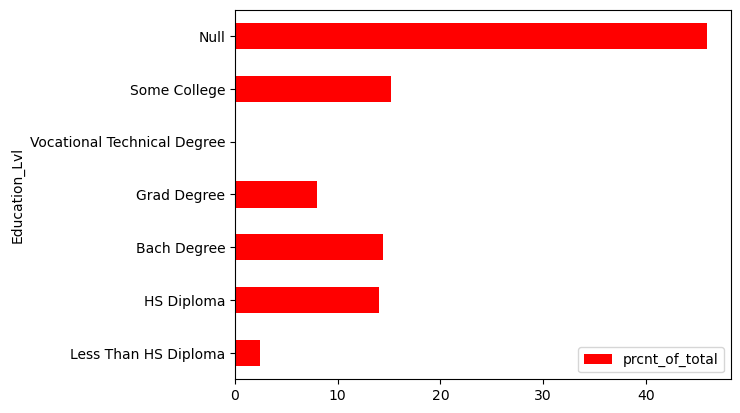

In [38]:
## visualize above
ed_lvl_state_pd_OR = ed_lvl_state_OR.toPandas()
ed_lvl_state_pd_OR.plot(kind='barh', x='Education_Lvl', y='prcnt_of_total', color='red')

As we can see, a majority of Oregon voters have a null value in the education level column (45.96% of voters). The next majority of voters have an education level listed as 'Some College' (15.15% of voters), while the lowerest number of voters have an education level listed as 'Vocational Technical Degree' (0.09% of voters).

We can go further by creating a table of this distribution of education level in voters for each Oregon County. We calculate  the total number of voters in each county, and both the number and proportion of voters of each education level within each county.

In [39]:
## find counts and proportions of each level of education for each county in the state of Oregon
county_voters_OR = OR_df.groupBy('County').agg(countDistinct('LALVOTERID'))
county_voters_OR = county_voters_OR.withColumn("voter_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 

ed_lvl_county_cnt_OR = OR_df.groupBy(['County','Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_county_cnt_OR = ed_lvl_county_cnt_OR.withColumn("ed_level_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 
ed_lvl_by_county_OR = ed_lvl_county_cnt_OR.join(county_voters_OR, 'County').orderBy('County')
ed_lvl_by_county_OR = ed_lvl_by_county_OR.withColumn("prcnt_of_total", round(((col("ed_level_total")/col("voter_total"))*100), 2))
ed_lvl_by_county_OR.show()

+---------+--------------------+--------------+-----------+--------------+
|   County|       Education_Lvl|ed_level_total|voter_total|prcnt_of_total|
+---------+--------------------+--------------+-----------+--------------+
|    BAKER|Less Than HS Diploma|           409|      13590|          3.01|
|    BAKER|         Grad Degree|           701|      13590|          5.16|
|    BAKER|Vocational Techni...|            15|      13590|          0.11|
|    BAKER|         Bach Degree|          1890|      13590|         13.91|
|    BAKER|                Null|          5720|      13590|         42.09|
|    BAKER|        Some College|          2206|      13590|         16.23|
|    BAKER|          HS Diploma|          2649|      13590|         19.49|
|   BENTON|Vocational Techni...|            39|      64136|          0.06|
|   BENTON|         Bach Degree|         10882|      64136|         16.97|
|   BENTON|          HS Diploma|          5895|      64136|          9.19|
|   BENTON|Less Than HS D

##### _Note: the below code chunk typically creates a histogram for each education level in the above table to visualize county distributions for each level, but it is commented out in order to preserve both report length and computation time._

In [41]:
# ## visualize distribution across counties for each level of education

# ## distribution of grad degrees per county
# grad_dgs_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "Grad Degree")
# grad_dgs_by_county_pd_OR = grad_dgs_by_county_OR.toPandas()
# grad_dgs_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='summer', title='Graduate Degree')

# ## distribution of bach degrees per county
# bach_dgs_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "Bach Degree")
# bach_dgs_by_county_pd_OR = bach_dgs_by_county_OR.toPandas()
# bach_dgs_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='magma', title='Bachelors Degree')

# ## distribution of vocational technical degrees per county
# voc_dgs_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "Vocational Technical Degree")
# voc_dgs_by_county_pd_OR = voc_dgs_by_county_OR.toPandas()
# voc_dgs_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='autumn', title='Vocational Technical Degree')

# ## distribution of some college per county
# some_col_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "Some College")
# some_col_by_county_pd_OR = some_col_by_county_OR.toPandas()
# some_col_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='twilight', title='Some College')

# ## distribution of hs diploma per county
# hs_dip_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "HS Diploma")
# hs_dip_by_county_pd_OR = hs_dip_by_county_OR.toPandas()
# hs_dip_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='ocean', title='High School Diploma')

# ## distribution of less than hs diploma per county
# less_thn_hs_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "Less Than HS Diploma")
# less_thn_hs_by_county_pd_OR = less_thn_hs_by_county_OR.toPandas()
# less_thn_hs_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='seismic', title='Less Than High School Diploma')

# ## distribution of null education level per county
# null_ed_lvl_by_county_OR = ed_lvl_by_county_OR.filter(ed_lvl_by_county_OR.Education_Lvl == "Null")
# null_ed_lvl_by_county_pd_OR = null_ed_lvl_by_county_OR.toPandas()
# null_ed_lvl_by_county_pd_OR.plot.barh(x='County', y='prcnt_of_total', colormap='spring', title='Null Values')

By joining the table above to our elections results and voter turnout tables, we can find the counties with the highest and lowest proportions of voters in each education level, and see how this might relate to their overall voter turnout and election outcome. As 'Vocational Technical Degree' and 'Less Than High School Diploma' are the levels with the lowest proportion of voters in the dataset, we are going to leave them out of this portion of our exploration. 

In [57]:
# comparing voter turnout vs. education level by county
ed_lvl_turnout_OR = ed_lvl_by_county_OR.join(voter_turnout_OR_CLEAN, 'County').orderBy('County', 'Education_Lvl')
# comparing voter turnout and election outcome vs. education level by county
ed_lvl_turnout_outcome_OR = ed_lvl_turnout_OR.join(election_results_OR_CLEAN, 'County').orderBy('County', 'Education_Lvl')
# ed_lvl_turnout_outcome_OR.show()

In [58]:
# find min and max values for proportion of voters in education level
ed_lvl_turnout_outcome_OR.filter(col('Education_Lvl') == "Grad Degree").select(max('prcnt_of_total'), min('prcnt_of_total')).show()
ed_lvl_turnout_outcome_OR.filter(col('Education_Lvl') == "Bach Degree").select(max('prcnt_of_total'), min('prcnt_of_total')).show()
ed_lvl_turnout_outcome_OR.filter(col('Education_Lvl') == "Some College").select(max('prcnt_of_total'), min('prcnt_of_total')).show()
ed_lvl_turnout_outcome_OR.filter(col('Education_Lvl') == "HS Diploma").select(max('prcnt_of_total'), min('prcnt_of_total')).show()

+-------------------+-------------------+
|max(prcnt_of_total)|min(prcnt_of_total)|
+-------------------+-------------------+
|              14.95|               3.69|
+-------------------+-------------------+



+-------------------+-------------------+
|max(prcnt_of_total)|min(prcnt_of_total)|
+-------------------+-------------------+
|              18.99|               9.59|
+-------------------+-------------------+



+-------------------+-------------------+
|max(prcnt_of_total)|min(prcnt_of_total)|
+-------------------+-------------------+
|              20.26|              11.59|
+-------------------+-------------------+



+-------------------+-------------------+
|max(prcnt_of_total)|min(prcnt_of_total)|
+-------------------+-------------------+
|              23.62|               9.19|
+-------------------+-------------------+



In [59]:
# find counties with min and max proportions of grad degree
max_grad_prop_OR = ed_lvl_turnout_outcome_OR.filter((col('Education_Lvl') == "Grad Degree") & (col('prcnt_of_total')==14.95))
max_grad_prop_OR.show()
min_grad_prop_OR = ed_lvl_turnout_outcome_OR.filter((col('Education_Lvl') == "Grad Degree") & (col('prcnt_of_total')==3.69))
min_grad_prop_OR.show()

+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|BENTON|  Grad Degree|          9590|      64136|         14.95|              86|                 98|                 96|                   64|              60|              28|          29193|          13445|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+

+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|MORROW|  Grad Degree|           263|       7130|          3.69|              77|                 91|                100|                   51|              24|              65|           1017|           2721|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+

Benton county has the highest proportion of voters with Graduate degrees reported in the state of Oregon, with 14.95% of voters reported as having Graduate Degrees. Their county voter turnout is overall fairly high (98% registered Democrats, 96% registered Republicans, 64% registered Independent/Other), and Benton is one of three counties with the highest overall voter turnout in the state (86% all registered voters). From our previous findings, we know that Benton county is the Oregon county with the largest proportion of registered Independent/Other voters (64%), so this is an interesting find. Additionally, Benton county is one of the 8 Oregon counties in which the Democrat presidential candidate won the majority vote. 

Morrow county has the lowest proportion of voters with Graduate degrees reported in the state of Oregon, with 3.69% of voters  reported as having Graduate Degrees. Their voter turnout for all registered voters, Independent/Other voters, and registered Democrats is slightly lower than we have seen overall (77%, 51%, and 91% respectively), but they are one of the 21 counties with 100% voter turnout for registered Republicans. Additionally, they are also one of the 28 Oregon counties in which the Republican presidential candidate won the majority vote.

In [60]:
# find counties with min and max proportions of bachelor degree
max_bach_prop_OR = ed_lvl_turnout_outcome_OR.filter((col('Education_Lvl') == "Bach Degree") & (col('prcnt_of_total')==18.99))
max_bach_prop_OR.show()
min_bach_prop_OR = ed_lvl_turnout_outcome_OR.filter((col('Education_Lvl') == "Bach Degree") & (col('prcnt_of_total')==9.59))
min_bach_prop_OR.show()

+----------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|    County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+----------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|WASHINGTON|  Bach Degree|         76729|     403997|         18.99|              81|                 94|                 97|                   59|              57|              31|         153251|          83197|
+----------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+-------------------

+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|MORROW|  Bach Degree|           684|       7130|          9.59|              77|                 91|                100|                   51|              24|              65|           1017|           2721|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+

Washington county has the highest proportion of voters with Bachelor Degrees reported in the state of Oregon, with 18.99% of voters reported as having Bachelor Degrees. This county also saw relatively high voter turnout across all categories (81% all registered voters, 94% Democrat voters, 97% Republican voters, 59% Independent/Other voters). Additionally, Washington county was one of the 8 Oregon counties in which the Democrat presidential candidate won the majority vote.

Morrow county not only has the lowest proportion of voters with Graduate Degrees, but also has the lowest proportion of voters with Bachelor Degrees. This is a notable find because, as mentioned above, Morrow county is one of the 21 Oregon counties with 100% Republican voter turnout, and one of the 28 Oregon counties in which the Republican presidential candidate won the majority vote.

In [61]:
# find counties with min and max proportions of some college
max_some_col_prop_OR = ed_lvl_turnout_outcome_OR.filter((col('Education_Lvl') == "Some College") & (col('prcnt_of_total')==20.26))
max_some_col_prop_OR.show()
min_some_col_prop_OR = ed_lvl_turnout_outcome_OR.filter((col('Education_Lvl') == "Some College") & (col('prcnt_of_total')==11.59))
min_some_col_prop_OR.show()

+-------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
| County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+-------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|SHERMAN| Some College|           313|       1545|         20.26|              85|                 91|                100|                   56|              20|              72|            202|            732|
+-------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+------------

+---------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|   County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+---------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|MULTNOMAH| Some College|         73282|     632361|         11.59|              81|                 97|                 94|                   54|              73|              17|         292561|          67954|
+---------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+--

Sherman county has the highest proportion of voters with 'Some College' complete in the state of Oregon, with 20.26% of voters reported as having completed 'Some College'. Sherman county has fairly high voter turnout overall (85% all registered voters, 91% Democrat, 56% Independent/Other), and is one of the 21 counties that have 100% Republican voter turnout. Additionally, they are one of the 28 counties in which the Republican presidential candiate won the majority vote.

Multnomah county has the lowest proportion of voters with 'Some College' complete in the state of Oregon, with 11.59% of voters reported as having completed 'Some College'. This is particularly interesting, as we have previously found that Multnomah county had the lowest Republican voter turnout rate in the state (94%), the highest proportion of votes for Clinton in the state (73%), the lowest proportion of votes for Trump in the state (17%), and it is the only county with the highest median numbers of years of education in voters (7 years).

In [62]:
# find counties with min and max proportions of hs diploma
max_hs_prop_OR = ed_lvl_turnout_outcome_OR.filter((col('Education_Lvl') == "HS Diploma") & (col('prcnt_of_total')==23.62))
max_hs_prop_OR.show()
min_hs_prop_OR = ed_lvl_turnout_outcome_OR.filter((col('Education_Lvl') == "HS Diploma") & (col('prcnt_of_total')==9.19))
min_hs_prop_OR.show()

+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|HARNEY|   HS Diploma|          1421|       6017|         23.62|              86|                 94|                100|                   59|              17|              73|            683|           2912|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+

+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|BENTON|   HS Diploma|          5895|      64136|          9.19|              86|                 98|                 96|                   64|              60|              28|          29193|          13445|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+

Harney county has the highest proportion of voters having only completed High School in the state of Oregon, with 23.62% of voters reported as 'High School Diploma' for their education level. Harney county is one of three counties with the highest overall voter turnout in the state of Oregon (86% of all registered voters), as well as one of the 21 Oregon counties with 100% Republican voter turnout. They also have relatively high Democrat and Independent/Other voter turnout (94% and 59% respectively), and they are one of the 28 counties in which the Republican presidential candidate won the majority vote.

Benton county not only has the highest proportion of voters with reported Graduate Degrees in the state, but it is also the county with the lowest proportion of voters having only completed High School in the state. This is interesting because, as stated above, they are also one of three counties with the highest overall voter turnout in the state of Oregon (86% of all registered voters, as well as the largest proportion of registered Independent/Other voters  in the state (64%).

### Conclusions

Overall, from our exploratory data analysis of the state of Oregon, a historically 'Blue' state, we were able to draw some conclusions about the relationship between education, voter turnout, and election outcome. 
<br>

Our findings relating median eduation years to voter turnout and election outcome support the theory of a correlation between education, voter turnout, and election outcome. We found that counties with the lowest median years of education in voters voted much more in favor of the Republican presidential candidate, and had an overall higher Republican voter turnout relative to other Oregon counties. 
<br>

Our findings relating voter education level to voter turnout and election outcome also support the theory of correlation between education, voter turnout, and election outcome. They should be taken with a grain of salt, as there were so many null Education Level values for voters within the state of Oregon. However, we can draw the following conclusions from this exploration:
<br>

Counties with the highest proportions of voters with higher levels of education:
* Had overall high Democrat, Independent, and All registered voter turnout relative to other counties 
* Had slightly lower Republican voter turnout relative to other counties 
* Had a higher proportion of voters voting for the Democrat presidential candidiate
<br>

Counties with the lowest proportions of voters with higher levels of education:
* Had the highest Republican voter turnout relative to other counties
* Had a higher proportion of voters voting for the Republican presidential candidate